# Examples GEM EO datasets of derived data

This is a notebook showcasing workflow examples for downloading EO derived data from data collections available through Sentinel Hub.

### Data download examples in this notebook:


1.  Climate Indicators

3.  Drone imagery

In [169]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from eolearn.core import EOPatch, FeatureType
from eolearn.io import SentinelHubEvalscriptTask
from sentinelhub import CRS, Band, BBox, DataCollection, Unit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### General parameters

In [231]:
# region of interest
europe_bbox = BBox(bbox=(-12.128906, 34.885931, 40.781250, 71.965388), crs=CRS.WGS84)

###  1.  Climate Indicators

In [185]:
band_names = [
    "tavg_ref_1995_2015",
    "tavg_ssp_45_proj_2030",
    "tavg_ssp_45_proj_2050",
    "tavg_ssp_45_proj_2070",
    "tavg_ssp_85_proj_2030",
    "tavg_ssp_85_proj_2050",
    "tavg_ssp_85_proj_2070",
]

temperature_indicators_collection = DataCollection.define_byoc(
    "4004f3ee-e5d9-4c2b-a937-de32781b1b91",
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in band_names],
)

In [220]:
from matplotlib.colors import LinearSegmentedColormap

ramp = [
    [-3, 0x0008FF],
    [-1.43, 0x0043FF],
    [0.14, 0x004EFF],
    [1.71, 0x0095FF],
    [3.29, 0x00ADFF],
    [4.86, 0x00F3FF],
    [6.43, 0x00FFFF],
    [8.00, 0xCCFF00],
    [9.57, 0xFFEB00],
    [11.14, 0xFFBC00],
    [12.71, 0xFFA500],
    [14.29, 0xFF8100],
    [15.86, 0xFF6A00],
    [17.43, 0xFF0C00],
    [19, 0xC80000],
]

colormap = LinearSegmentedColormap.from_list("dsd", [f"#{hex(color)[2:].zfill(6)}" for _, color in ramp])

In [221]:
def create_evalscript(band: str) -> str:
    return f"""//VERSION=3
function setup() {{
  return {{
  input: ["{band}", "dataMask"],
  output: [
    {{ id: "{band}", bands: 1, sampleType: SampleType.FLOAT32 }},
    {{ id: "dataMask", bands: 1, sampleType: SampleType.AUTO }}
  ]}};
}}
function evaluatePixel(sample) {{
  return {{ "{band}": [sample.{band}],
            "dataMask": [sample.dataMask]}};
}}
"""

In [222]:
eopatch = EOPatch(bbox=europe_bbox)

In [223]:
band_name = band_names[0]

for band_name in band_names:
    print(f"Downloading data for {band_name}...")
    indicator_download_task = SentinelHubEvalscriptTask(
        features=[(FeatureType.DATA, band_name), (FeatureType.MASK, "dataMask")],
        evalscript=create_evalscript(band_name),
        data_collection=temperature_indicators_collection,
        resolution=10000,
        max_threads=3,
    )
    eopatch = indicator_download_task.execute(
        eopatch=eopatch, bbox=europe_bbox, time_interval=["2024-01-01", "2024-01-02"]
    )

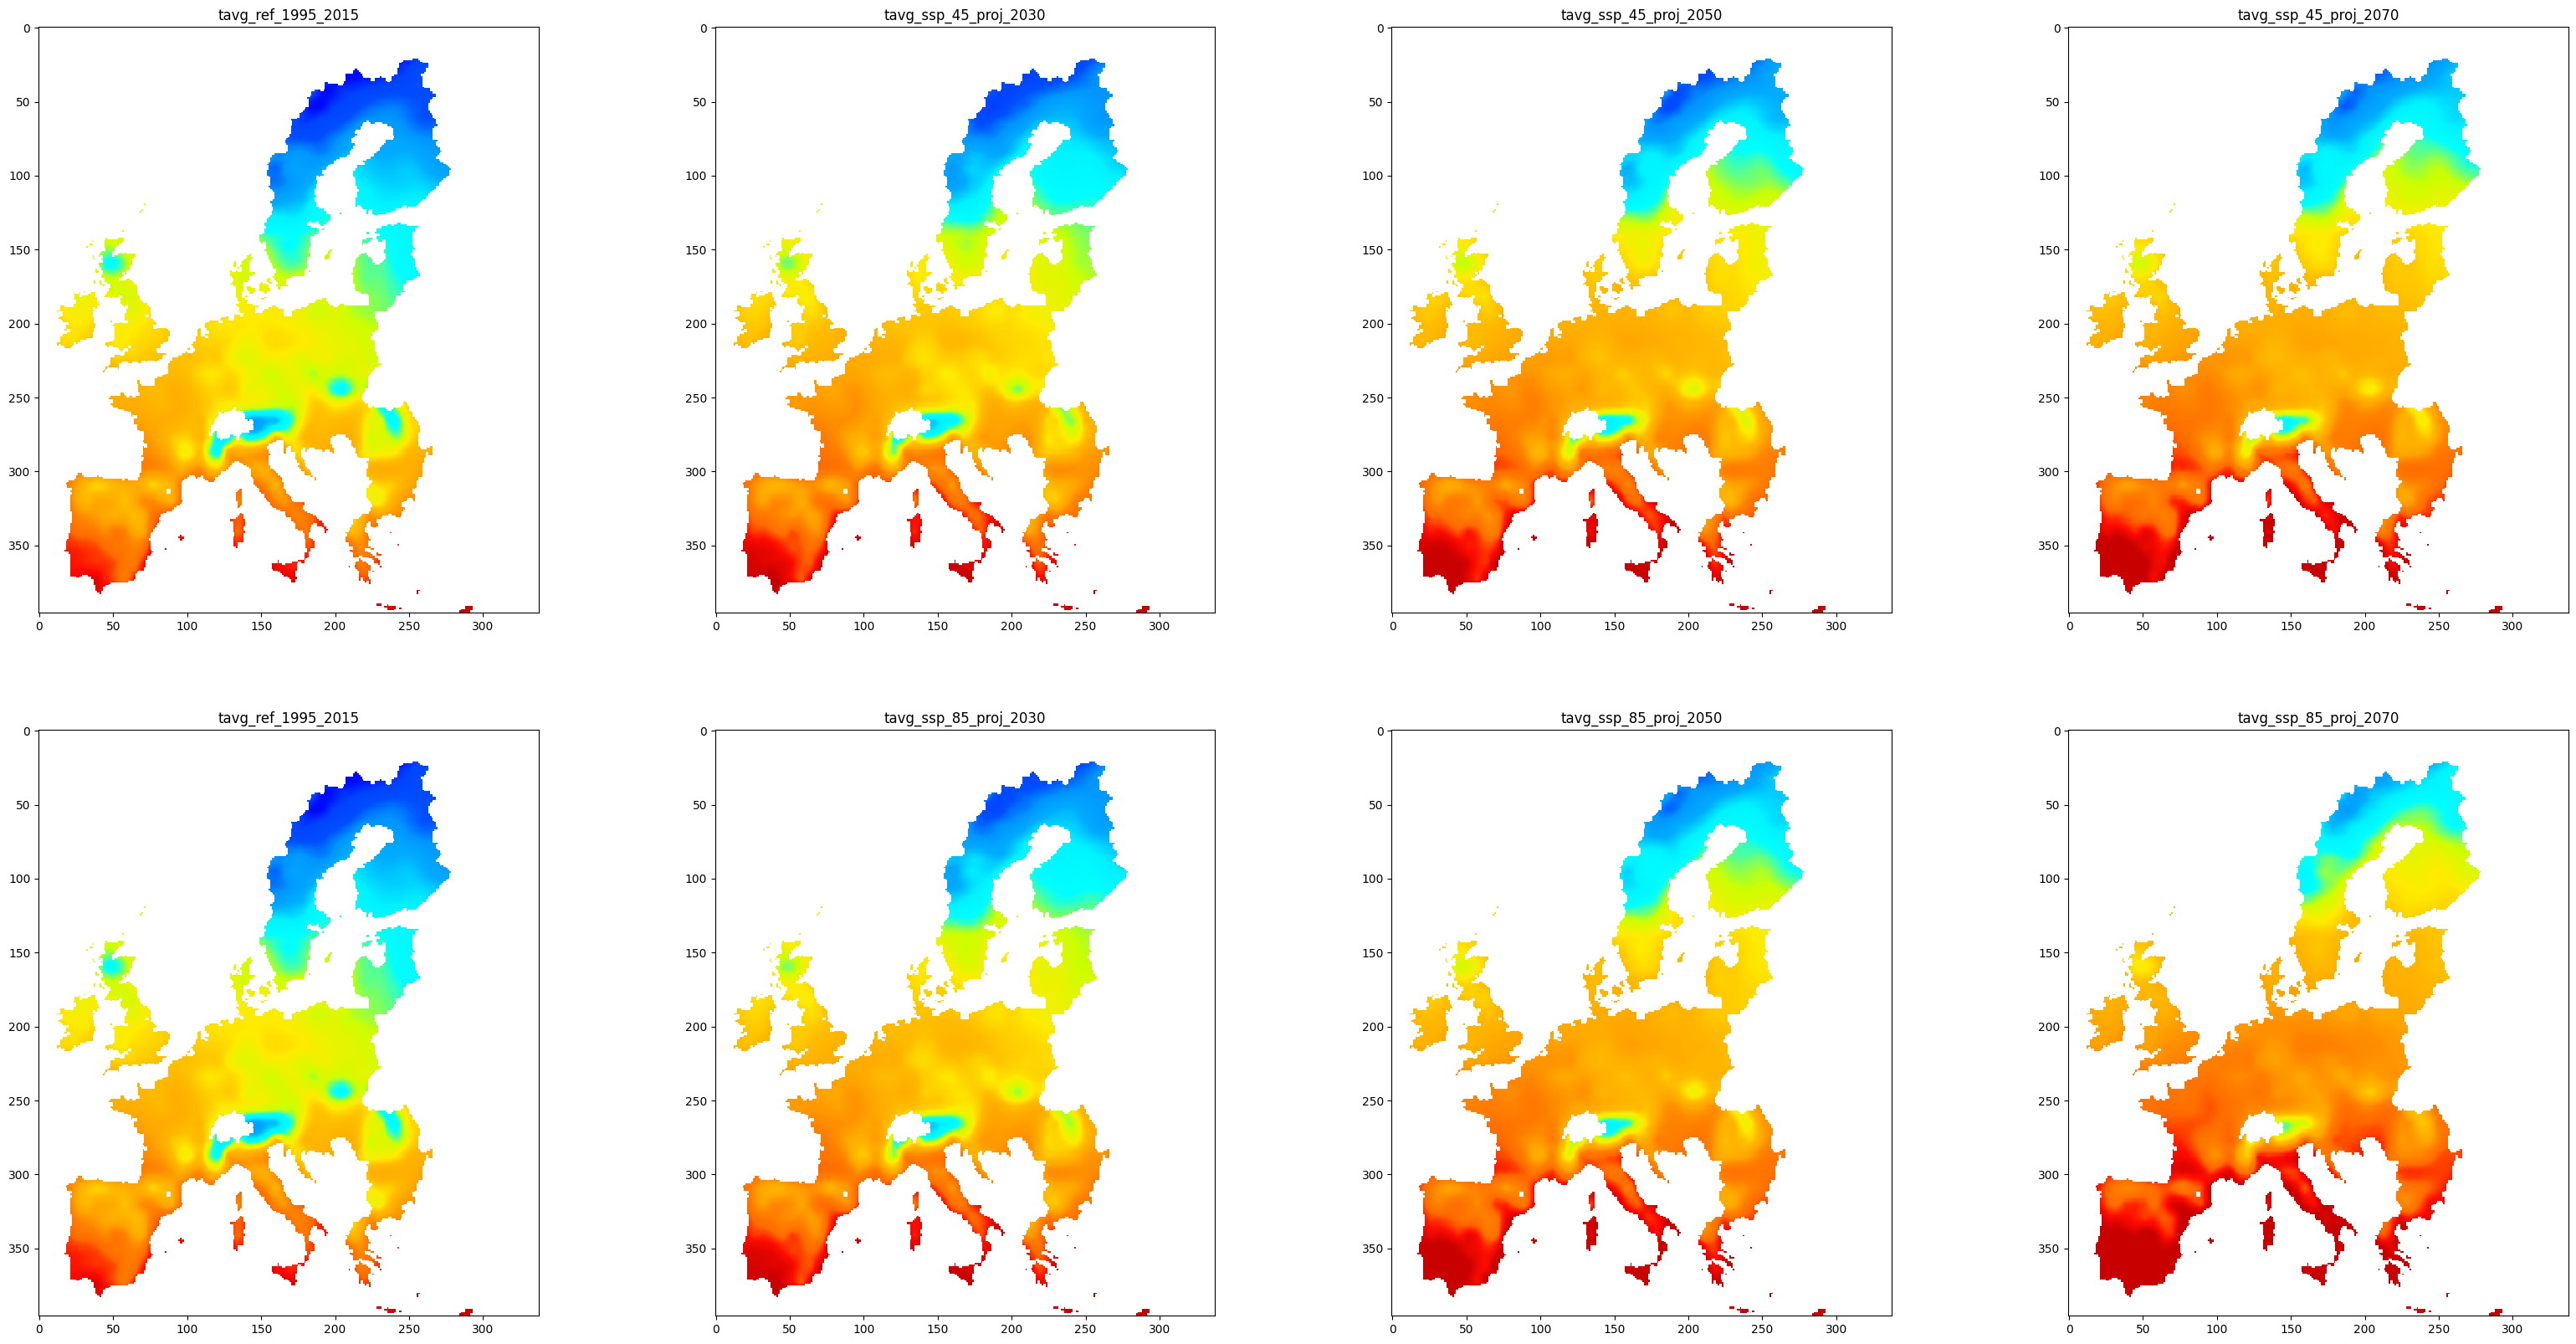

In [230]:
ncols = 4
nrows = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 10 * nrows))

# Plot reference and SSP 4.5
for i, band_name in enumerate(band_names[:4]):
    indicator_data = eopatch.data[band_name][0].squeeze()
    indicator_data[eopatch.mask["dataMask"].squeeze() == 0] = np.nan

    axs[0][i].imshow(indicator_data, cmap=colormap, vmin=-3, vmax=19)
    axs[0][i].set_title(band_name)

# Plot reference and SSP 8.5
for i, band_name in enumerate([band_names[0]] + band_names[4:]):
    indicator_data = eopatch.data[band_name][0].squeeze()
    indicator_data[eopatch.mask["dataMask"].squeeze() == 0] = np.nan

    axs[1][i].imshow(indicator_data, cmap=colormap, vmin=-3, vmax=19)
    axs[1][i].set_title(band_name)